# Estimation of standard deviations, normalization, and background subtraction for x-ray scattering data

Import packages.

In [44]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from diffpy.utils.parsers.loaddata import loadData
from skbeam.core.utils import q_to_twotheta
import matplotlib.pyplot as plt

Define characters to use for splitting filenames into basename, scan number, and sequential number if present.

In [45]:
SCAN_SPLIT_CHAR = "_"
SCAN_SEQ_SPLIT_CHAR = "-"

Plot settings.

In [46]:
CMAPS = {0:'viridis', 1:'plasma', 2:'inferno', 3:'magma', 4:'Greys',
         5:'Purples', 6:'Blues', 7:'Greens', 8:'Oranges', 9:'Reds',
         10: 'YlOrBr', 11:'YlOrRd', 12:'OrRd', 13:'PuRd', 14:'RdPu',
         15:'BuPu', 16:'GnBu', 17:'PuBu', 18:'YlGnBu', 19:'PuBuGn',
         20:'BuGn', 21:'YlGn', 22:'binary', 23:'gist_yarg', 24:'gist_gray',
         25:'gray', 26:'bone', 27:'pink', 28:'spring', 29:'summer',
         30:'autumn', 31:'winter', 32:'cool', 33:'Wistia', 34:'hot',
         35:'afmhot', 36:'gist_heat', 37:'copper', 38:'PiYG', 39:'PRGn',
         40:'BrBG', 41:'PuOr', 42:'RdGy', 43:'RdBu', 44:'RdYlBu',
         45:'RdYlGn', 46:'Spectral', 47:'coolwarm', 48:'bwr', 49:'seismic',
         50:'twilight', 51:'twilight_shifted', 52:'hsv', 53:'ocean',
         54:'gist_earth', 55:'terrain', 56:'gist_stern', 57:'gnuplot',
         58:'gnuplot2', 59:'CMRmap', 60:'cubehelix', 61:'brg',
         62:'gist_rainbow', 63:'rainbow', 64:'jet', 65:'turbo',
         66:'nipy_spectral', 67:'gist_ncar'}

D_PLOT = dict(dpi=600,
              figsize=(8, 4),
              fontsize_labels=20,
              fontsize_ticks=14,
              linewidth=1,
              cmap=f"{CMAPS[25]}_r",
              )

Various function definitions.

In [47]:
def comma_to_dot(files):
    with files[0].open(mode="r") as f:
        s = f.read()
    if "," in s:
        parent = files[0].parent.name
        comma_to_dot_path = files[0].parent.parent / f"{parent}_comma_to_dot"
        if not comma_to_dot_path.exists():
            comma_to_dot_path.mkdir()
        print(f"{80*'-'}\nConverting commas to dots...")
        for e in files:
            print(f"\t{e.name}")
            with e.open(mode="r") as f:
                s = f.read().replace(",", ".")
            fname = comma_to_dot_path / e.name
            with fname.open(mode="w", encoding="utf-8") as o:
                o.write(s)
        print(f"Done converting commas to dots.")

    return None


def data_files_to_dict(data_files, scan_split_index, scan_split_index2, type):
    d = {}
    if type == "data":
        for f in data_files:
            if isinstance(scan_split_index2, int):
                scan = f.stem.split(SCAN_SPLIT_CHAR)[scan_split_index]
                scan = int(scan.split(SCAN_SEQ_SPLIT_CHAR)[scan_split_index2])
            else:
                scan = int(f.stem.split(SCAN_SPLIT_CHAR)[scan_split_index])
            d[scan] = loadData(str(f))
    elif type == "bkg":
        for f in data_files:
            d["bkg"] = loadData(str(f))

    return d


def esd_calculator_writer(data_dict, basename, file_ext, zfill, wl, sdd,
                          xtype, xunit, type):
    for k in sorted(data_dict.keys()):
        x, y, = data_dict[k][:,0], data_dict[k][:,1]
        if xtype == r'$Q$' and xunit == r'$[\mathrm{\AA}^{-1}]$':
            x_rad = q_to_twotheta(x, wl)
        elif xtype == r'$Q$' and xunit == r'$[\mathrm{nm}^{-1}]$':
            x_rad = q_to_twotheta(x / 10, wl)
        elif xtype == r'$2\theta$' and xunit == r'$[\degree]$':
            x_rad = np.radians(x)
        normalizer = np.array([2*np.pi*sdd*np.tan(x_rad[i])/0.150
                              for i in range(len(x))])
        esd = np.sqrt(y / normalizer)
        xye = np.column_stack((x, y, esd))
        if type == "data":
            fname = f"{basename}_s_{str(k).zfill(zfill)}{file_ext}"
            output_path = Path.cwd() / "data_esd" / fname
        elif type == "bkg":
            fname = f"{basename}_s{file_ext}"
            output_path = Path.cwd() / "bkg_esd" / fname
        print(f"\t{fname}")
        np.savetxt(output_path, xye, fmt="%.18e", delimiter="\t",
                   encoding="utf-8")

    return None


def basecase_calculator(file_ext, scale_xmin, scale_xmax):
    esd_file = list((Path.cwd() / "data_esd").glob(f"*{file_ext}"))[0]
    basecase = 0
    with esd_file.open(mode="r") as f:
        xy = np.loadtxt(f)
        x, y = xy[:,0], xy[:,1]
        for i in range(len(x)):
            if scale_xmin <= x[i] <= scale_xmax:
                basecase += y[i]

    return basecase


def norm_factor(filename, basecase, scale_xmin, scale_xmax):
    intensity, intensity_sum = 0, 0
    xy = np.loadtxt(filename)
    x, y = xy[:,0], xy[:,1]
    for i in range(len(y)):
        if scale_xmin <= x[i] <= scale_xmax:
            intensity_sum += y[i]
    if intensity_sum == 0:
        normalizer = 1
    else:
        normalizer = basecase / intensity_sum

    return normalizer


def normalizer(file_ext, basecase, scale_xmin, scale_xmax, type):
    files_esd = (Path.cwd() / f"{type}_esd").glob(f"*{file_ext}")
    for f in files_esd:
        fname = ''
        if type == "data":
            for e in f.name.split("_")[0:-2]:
                fname += f"{e}_"
            fname += f"ss_{f.name.split('_')[-1]}"
        elif type == "bkg":
            fname = f"{f.stem}s{f.suffix}"
        print(f"\t{fname}")
        factor = norm_factor(f, basecase, scale_xmin, scale_xmax)
        xye = np.loadtxt(f)
        x, y, e = xye[:,0], xye[:,1], xye[:,2]
        y_norm, e_norm = y * factor, e * factor
        np.savetxt(f"{type}_esd_normalized/{fname}",
            np.column_stack((x, y_norm, e_norm)))

    return None


def buf_writer(files_norm, buf_path):
    basename_split = files_norm[0].stem.split("_")
    basename = ""
    for e in basename_split[0:-1]:
        basename += f"{e}_"
    basename = basename.strip("_")
    buf_file_path = buf_path / f"{basename}.buf"
    s =""
    for e in files_norm:
        s += f"{e.name}\n"
    with buf_file_path.open(mode="w", encoding="utf-8") as o:
        o.write(s)

    return None


def extrema_collect(data_dict):
    keys = sorted(list(data_dict.keys()))
    for i in range(len(keys)):
        xy = data_dict[keys[i]]
        x, y = xy[:,0], xy[:,1]
        if i == 0:
            y_stack = y
        else:
            y_stack = np.column_stack((y_stack, y))
    xmin, xmax, xmin_index, xmax_index = None, None, 0, -1
    for i in range(len(y)-1):
        if y[i] == 0 and y[i+1] != 0:
            xmin_index = i
            xmin = x[i]
            break
    for i in range(xmin_index + 1, len(y) - 6):
        if y[i] == y[i+1] == y[i+2] == y[i+3] == y[i+4] == y[i+5] == y[i+6] ==0:
            xmax_index = i
            xmax = x[i]
            break
    if isinstance(xmin, type(None)):
        xmin = np.amin(x)
    if isinstance(xmax, type(None)):
        xmax = np.amax(x)

    return xmin, xmax, xmin_index, xmax_index


def dict_bkg_subtract(data_dict_norm, bkg_dict_norm):
    bkg_scale_list = []
    bkg_scale = 1
    y_bkg_norm = bkg_dict_norm["bkg"][:,1]
    for k in data_dict_norm.keys():
        xy = data_dict_norm[k]
        x, y = xy[:,0], xy[:,1]
        y_bkg = bkg_scale * y_bkg_norm
        bool_list = y >= y_bkg
        while False in bool_list:
            bkg_scale = bkg_scale * 0.999
            y_bkg = bkg_scale * y_bkg_norm
            bool_list = y >= y_bkg
        bkg_scale_list.append(bkg_scale)
    bkg_scale = min(bkg_scale_list)
    y_bkg_scaled = bkg_scale * bkg_dict_norm["bkg"][:,1]
    data_dict_bkg_sub = {}
    for k in data_dict_norm.keys():
        xy = data_dict_norm[k]
        x, y = xy[:,0], xy[:,1]
        y_bkg_sub = y - y_bkg_scaled
        data_dict_bkg_sub[k] = np.column_stack((x, y_bkg_sub))

    return data_dict_bkg_sub


def dict_bkg_sub_writer(data_dict_bkg_sub, basename, file_ext, output_path,
                        zfill):
    for k in data_dict_bkg_sub.keys():
        xy = data_dict_bkg_sub[k]
        fname = f"{basename}_{str(k).zfill(zfill)}_ss_bkgsub"f"{file_ext}"
        file_path = output_path / fname
        np.savetxt(file_path, xy, fmt="%.18e", delimiter="\t", encoding="utf-8")

    return None


def array_from_dict(d):
    for i, k in enumerate(d.keys()):
        if i == 0:
            array = np.column_stack((d[k][:, 0], d[k][:, 1]))
        else:
            array = np.column_stack((array, d[k][:, 1]))

    return array

Plot function definitions.

In [48]:
def stack_plotter(data_dict, 
                  basename, 
                  xtype, 
                  xunit,
                  d_plot, 
                  plot_paths, 
                  type,
                  mode,
                  ):
    if mode == "save":
        fig, ax = plt.subplots(dpi=d_plot["dpi"], figsize=d_plot["figsize"])
    else:
        fig, ax = plt.subplots(figsize=d_plot["figsize"])
    for k in data_dict.keys():
        x, y = data_dict[k][:,0], data_dict[k][:,1]
        ax.plot(x, y, c=np.random.rand(3,), lw=0.3)
    ax.set_xlim(np.amin(x), np.amax(x))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xlabel(f"{xtype} {xunit}", fontsize=d_plot["fontsize_labels"])
    ax.set_ylabel("$I\;[\mathrm{arb. u.}]$",
                  fontsize=d_plot["fontsize_labels"],
                  )
    ax.tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    if mode == "save":
        if type == "esd":
            suffix = "s"
        elif type == "scaled":
            suffix = "ss"
        elif type == "bkgsub":
            suffix = "ss_bkgsub"
        for p in plot_paths:
            plt.savefig(f"{p.name}/{basename}_{suffix}.{p.name}", 
                        bbox_inches='tight',
                        )
        plt.close()
    else:
        plt.show()

    return None


def data_dict_overview(data_dict, 
                       xlabel,
                       basename,
                       xmin,
                       xmax,
                       xmin_index,
                       xmax_index,
                       d_plot,
                       plot_paths,
                       mode,
                       ):
    keys = sorted(list(data_dict.keys()))
    for i in range(len(keys)):
        xy = data_dict[keys[i]]
        x, y = xy[:,0], xy[:,1]
        if i == 0:
            y_stack = y
        else:
            y_stack = np.column_stack((y_stack, y))
    y = np.flip(y_stack[xmin_index:xmax_index, :], axis=0)
    xrange = xmax - xmin
    if mode == "save":
        fig, ax = plt.subplots(dpi=d_plot["dpi"], figsize=d_plot["figsize"])
    else:
        fig, ax = plt.subplots(figsize=d_plot["figsize"])
    im = plt.imshow(y,
                    interpolation='nearest',
                    origin='lower',
                    vmin=np.amin(y), vmax=np.amax(y),
                    extent=(0, len(keys), xmax, xmin),
                    aspect="auto",
                    cmap=d_plot["cmap"],
                    )
    ax.xaxis.set_ticks_position('top')
    plt.tick_params(axis="both", labelsize=d_plot["fontsize_labels"])
    plt.title("Scan number", fontsize=d_plot["fontsize_labels"])
    plt.ylabel(xlabel, fontsize=d_plot["fontsize_labels"])
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(r"$I\;[\mathrm{arb. u.}]$",
                       fontsize=d_plot["fontsize_labels"],
                       )
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.tick_params(labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    if mode == "save":
        for p in plot_paths:
            plt.savefig(f"{p.name}/{basename}_overview.{p.name}", 
                        bbox_inches="tight",
                        )
        plt.close()
    else:
        plt.show()

    return None

Creating directory structure and checking for data and background files.

In [49]:
data_path = Path.cwd() / "data"
bkg_path = Path.cwd() / "bkg"
if not data_path.exists():
    data_path.mkdir()
    print(f"{80*'-'}\nA folder called 'data' has been created. Please "
            f"place your data files there and\nrerun the code. "
            f"\n{80*'-'}")
    sys.exit()
elif not bkg_path.exists():
    bkg_path.mkdir()
    print(f"{80*'-'}\nA folder called 'bkg' has been created. Please "
            f"place your backgorund file there\nand rerun the code."
            f"\n{80*'-'}")
    sys.exit()
data_files = list(data_path.glob("*.*"))
bkg_files = list(bkg_path.glob("*.*"))
if len(data_files) == 0:
    print(f"{80*'-'}\nNo data files found in the 'data' folder. Please "
            f"place your data files there and\nrerun the code.\n{80*'-'}")
    sys.exit()
elif len(bkg_files) == 0:
    print(f"{80*'-'}\nNo bkg file found in the 'bkg' folder. Please "
            f"place your bkg file there and\nrerun the code.\n{80*'-'}")
    sys.exit()
elif len(bkg_files) > 1:
    print(f"{80*'-'}\nMore than one bkg file found in the 'bkg' folder: "
            f"{[f.name for f in bkg_files]}\nPlease ensure that only one bkg "
            f"file is placed in the 'bkg' folder and rerun the\ncode."
            f"\n{80*'-'}")
    sys.exit()
data_files_exts, basenames = [], []
for f in data_files:
    if not f.suffix in data_files_exts:
        data_files_exts.append(f.suffix)
if len(data_files_exts) > 1:
    print(f"{80*'-'}\nMore than one file extension was found in the 'data' "
            f"folder: {data_files_exts}\nPlease ensure that only one type of "
            f"files are placed in the 'data' folder and\nrerun the code."
            f"\n{80*'-'}")
    sys.exit()
print(f"Number of {data_files_exts[0]} data files found: {len(data_files)}"
      f"\nBackground file: {bkg_files[0].name}")

Number of .chi data files found: 49
Background file: N1_PDF_NaTFSI.chi


Sorting data files.

In [50]:
scanseq_split = data_files[0].stem.split(SCAN_SPLIT_CHAR)
print(f"Splitting the filename '{data_files[0].name}' at "
        f"'{SCAN_SPLIT_CHAR}': ")
for i in range(len(scanseq_split)):
    print(f"\t{i}\t{scanseq_split[i]}")
scan_split_index = int(input("Please provide the integer for the entry "
                             "containing the scan number\n(possibly "
                             "more, e.g. the sequential number): "))
for f in data_files:
    fname_split = f.stem.split(SCAN_SPLIT_CHAR)
    basename = fname_split[0]
    for i in range(1, scan_split_index):
        basename += f"_{scanseq_split[i]}"
    if not basename in basenames:
        basenames.append(basename)
if len(basenames) > 1:
    print(f"{80*'-'}\nMore than one naming scheme was found in the 'data' "
            f"folder: {basenames}\nPlease ensure that only data files are "
            f"placed in the 'data' folder.\nThe bkg file should be placed in "
            f"the 'bkg' folder.\nPlease re-arrange your files and rerun the "
            f"code.\n{80*'-'}")
    sys.exit()

f_0 = data_files[0]
scan_syntax = f_0.stem.split(SCAN_SPLIT_CHAR)[scan_split_index]
if SCAN_SEQ_SPLIT_CHAR in scan_syntax:
    scan_syntax_split = scan_syntax.split(SCAN_SEQ_SPLIT_CHAR)
    print(f"{80*'-'}\nSplitting '{scan_syntax}' at "
            f"'{SCAN_SEQ_SPLIT_CHAR}'...")
    for i in range(len(scan_syntax_split)):
        print(f"\t{i}\t{scan_syntax_split[i]}")
    scan_split_index2 = int(input("Please state the integer for the "
                                  "entry of the scan number: "))
else:
    scan_split_index2 = None

Splitting the filename 'N1_MAAK_FPOH_p4_001.chi' at '_': 
	0	N1
	1	MAAK
	2	FPOH
	3	p4
	4	001


Ensuring that dots and not commas are used as decimal separators.

In [51]:
zfill = len(str(len(data_files)))
bkgname = bkg_files[0].stem
data_files_ext = data_files_exts[0]
comma_to_dot(data_files)
data_comma_to_dot_path = Path(f"{data_path}_comma_to_dot")
if data_comma_to_dot_path.exists():
    data_files = list(data_comma_to_dot_path.glob("*.*"))
comma_to_dot(bkg_files)
bkg_comma_to_dot_path = Path(f"{bkg_path}_comma_to_dot")
if bkg_comma_to_dot_path.exists():
    bkg_files = list(bkg_comma_to_dot_path.glob("*.*"))
print(f"Done converting commas to dots.")

Done converting commas to dots.


Loading data and background into dictionaries.

In [52]:
data_dict = data_files_to_dict(data_files, 
                               scan_split_index,
                               scan_split_index2, 
                               type="data",
                               )
bkg_dict = data_files_to_dict(bkg_files, 
                              scan_split_index,
                              scan_split_index2, 
                              type="bkg",
                              )
data_bkg_dict = data_files_to_dict(data_files,
                                   scan_split_index,
                                   scan_split_index2, 
                                   type="data",
                                   )
data_bkg_dict["bkg"] = bkg_dict["bkg"]
print("Done loading data and background into dictionaries.")

Done loading data and background into dictionaries.


Wavelength and sample-to-detector distance.

In [53]:
wl_sdd_path = Path.cwd() / "wl_sdd.txt"
if not wl_sdd_path.exists():
    wl = float(input(f"Please state the wavelength in Ångström: "))
    sdd = float(input(f"Please state the sample-to-detector-distance in mm: "))
    with wl_sdd_path.open(mode="w", encoding="utf-8") as o:
        o.write(f"wavelength: {wl}\nsample-to-detector-distance: {sdd}\n")
else:
    with wl_sdd_path.open(mode="r") as f:
        lines = f.readlines()
    for line in lines:
        if "wavelength" in line:
            wl = float(line.split()[1])
        elif "sample" in line:
            sdd = float(line.split()[1])
    print(f"{80*'-'}\nThe following wavelength (wl) and sample-to-detector-"
            f"distance (sdd) were read\nfrom the \n{wl_sdd_path.name} file:"
            f"\n\twl:\t{wl} Å\n\tsdd:\t{sdd} mm\n{80*'-'}")
    wl_sdd_conf = input("Please state whether these value are correct. "
                        "([y]/n): ")
    if not wl_sdd_conf.lower() in ["", "y", "n"]:
        wl_sdd_conf = input("Please state whether these value are correct."
                            "(y/n): ")
    if wl_sdd_conf.lower() == "n":
        wl = float(input(f"{80*'-'}\nPlease state the wavelength in "
                         f"Ångström: "))
        sdd = float(input(f"{80*'-'}\nPlease state the sample-to-detector-"
                          f"distance in mm: "))
    with wl_sdd_path.open(mode="w", encoding="utf-8") as o:
        o.write(f"wavelength: {wl}\nsample-to-detector-distance: {sdd}\n")

--------------------------------------------------------------------------------
The following wavelength (wl) and sample-to-detector-distance (sdd) were read
from the 
wl_sdd.txt file:
	wl:	0.20696 Å
	sdd:	207.24 mm
--------------------------------------------------------------------------------


x-axis quantity and unit.

In [54]:
print(f"Quantity and unit for the independent variable:"
      f"\n\t1\tfor Q in inverse Ångström."
      f"\n\t2\tfor Q in inverse nm."
      f"\n\t3\tfor 2theta in degrees."
      )
xtype = int(input("Please state the quantity on the x-axis: "))
if xtype == 1:
    xtype, xunit = r'$Q$', r'$[\mathrm{\AA}^{-1}]$'
elif xtype == 2:
    xtype, xunit = r'$Q$', r'$[\mathrm{nm}^{-1}]$'
elif xtype == 3:
    xtype, xunit = r'$2\theta$', r'$[\degree]$'

Quantity and unit for the independent variable:
	1	for Q in inverse Ångström.
	2	for Q in inverse nm.
	3	for 2theta in degrees.


Estimation of standard deviations.

In [55]:
esd_paths = [Path(f"{data_path}_esd"), Path(f"{bkg_path}_esd")]
for e in esd_paths:
    if not e.exists():
        e.mkdir()
    if "data" in e.name:
        data_esd_path = e
    elif "bkg" in e.name:
        bkg_esd_path = e
esd_calculator_writer(data_dict, basename, data_files_ext, zfill, wl, sdd,
                      xtype, xunit, type="data")
esd_calculator_writer(bkg_dict, bkgname, data_files_ext, zfill, wl, sdd,
                      xtype, xunit, type="bkg")
data_esd_files = list(data_esd_path.glob("*.*"))
bkg_esd_files = list(bkg_esd_path.glob("*.*"))
print(f"Done adding esds and writing to files.")

	N1_MAAK_FPOH_p4_s_01.chi
	N1_MAAK_FPOH_p4_s_02.chi
	N1_MAAK_FPOH_p4_s_03.chi
	N1_MAAK_FPOH_p4_s_04.chi
	N1_MAAK_FPOH_p4_s_05.chi
	N1_MAAK_FPOH_p4_s_06.chi
	N1_MAAK_FPOH_p4_s_07.chi
	N1_MAAK_FPOH_p4_s_08.chi
	N1_MAAK_FPOH_p4_s_09.chi
	N1_MAAK_FPOH_p4_s_10.chi
	N1_MAAK_FPOH_p4_s_11.chi
	N1_MAAK_FPOH_p4_s_12.chi
	N1_MAAK_FPOH_p4_s_13.chi
	N1_MAAK_FPOH_p4_s_14.chi
	N1_MAAK_FPOH_p4_s_15.chi
	N1_MAAK_FPOH_p4_s_16.chi
	N1_MAAK_FPOH_p4_s_17.chi
	N1_MAAK_FPOH_p4_s_18.chi
	N1_MAAK_FPOH_p4_s_19.chi
	N1_MAAK_FPOH_p4_s_20.chi
	N1_MAAK_FPOH_p4_s_21.chi
	N1_MAAK_FPOH_p4_s_22.chi
	N1_MAAK_FPOH_p4_s_23.chi
	N1_MAAK_FPOH_p4_s_24.chi
	N1_MAAK_FPOH_p4_s_25.chi
	N1_MAAK_FPOH_p4_s_26.chi
	N1_MAAK_FPOH_p4_s_27.chi
	N1_MAAK_FPOH_p4_s_28.chi
	N1_MAAK_FPOH_p4_s_29.chi
	N1_MAAK_FPOH_p4_s_30.chi
	N1_MAAK_FPOH_p4_s_31.chi
	N1_MAAK_FPOH_p4_s_32.chi
	N1_MAAK_FPOH_p4_s_33.chi
	N1_MAAK_FPOH_p4_s_34.chi
	N1_MAAK_FPOH_p4_s_35.chi
	N1_MAAK_FPOH_p4_s_36.chi
	N1_MAAK_FPOH_p4_s_37.chi
	N1_MAAK_FPOH_p4_s_38.chi
	N1_MAAK_FPO

Creating plot directories.

In [56]:
png_path, pdf_path = Path.cwd() / "png", Path.cwd() / "pdf"
svg_path = Path.cwd() / "svg"
plot_paths = [png_path, pdf_path, svg_path]
for p in plot_paths:
    if not p.exists():
        p.mkdir()
print(f"Plot directories exist.")

Plot directories exist.


Stack plot of data and background files.

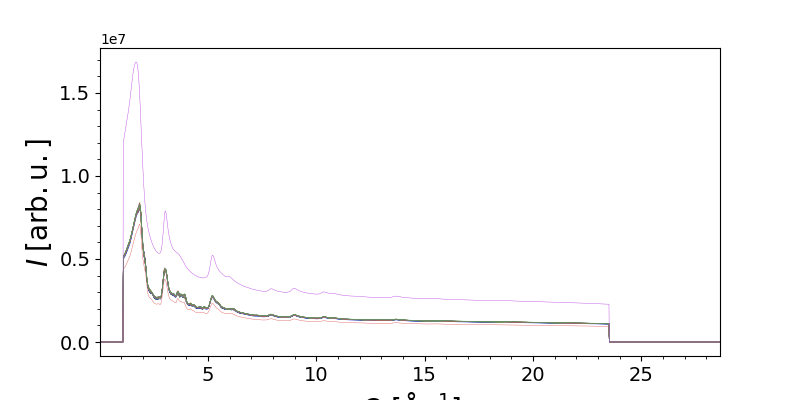

In [57]:
%matplotlib widget
stack_plotter(data_bkg_dict, 
              basename, 
              xtype, 
              xunit, 
              D_PLOT, 
              plot_paths, 
              type="esd", 
              mode="show",
              )

Save stack plot.

In [58]:
stack_plotter(data_bkg_dict,
              basename, 
              xtype, 
              xunit, 
              D_PLOT, 
              plot_paths, 
              type="esd", 
              mode="save",
              )
plot_folders = [p.name for p in plot_paths]
print(f"Stack plot of data files and bkg saved to the {plot_folders} folders.")

Stack plot of data files and bkg saved to the ['png', 'pdf', 'svg'] folders.


x-range to base the normalization on.

In [59]:
scale_xmin = float(input(f"Lower limit of the {xtype.strip('$')} range to "
                         f"scale within: "))
scale_xmax = float(input(f"Upper limit of the {xtype.strip('$')} range to "
                         f"scale within: "))

Normalization of data and background.

In [60]:
basecase = basecase_calculator(data_files_ext, scale_xmin, scale_xmax)
norm_paths = [Path(f"{data_esd_path}_normalized"), 
              Path(f"{bkg_esd_path}_normalized"),
              ]
for e in norm_paths:
    if not e.exists():
        e.mkdir()
    if "data" in e.name:
        data_norm_path = e
    elif "bkg" in e.name:
        bkg_norm_path = e
data_scaled = normalizer(data_files_ext, 
                         basecase, 
                         scale_xmin, 
                         scale_xmax, 
                         type="data",
                         )
data_scaled = normalizer(data_files_ext, 
                         basecase, 
                         scale_xmin, 
                         scale_xmax, 
                         type="bkg",
                         )
buf_path = Path.cwd() / "buf_esd_normalized"
if not buf_path.exists():
    buf_path.mkdir()
files_norm = list(data_norm_path.glob(f"*{data_files_ext}"))
files_norm.append(list(bkg_norm_path.glob(f"*{data_files_ext}"))[0])
buf_writer(files_norm, buf_path)
print("Done normalizing data. Normalized data written to xy-files and .buf "
      "file.")

	N1_MAAK_FPOH_p4_ss_01.chi
	N1_MAAK_FPOH_p4_ss_02.chi
	N1_MAAK_FPOH_p4_ss_03.chi
	N1_MAAK_FPOH_p4_ss_04.chi
	N1_MAAK_FPOH_p4_ss_05.chi
	N1_MAAK_FPOH_p4_ss_06.chi
	N1_MAAK_FPOH_p4_ss_07.chi
	N1_MAAK_FPOH_p4_ss_08.chi
	N1_MAAK_FPOH_p4_ss_09.chi
	N1_MAAK_FPOH_p4_ss_10.chi
	N1_MAAK_FPOH_p4_ss_11.chi
	N1_MAAK_FPOH_p4_ss_12.chi
	N1_MAAK_FPOH_p4_ss_13.chi
	N1_MAAK_FPOH_p4_ss_14.chi
	N1_MAAK_FPOH_p4_ss_15.chi
	N1_MAAK_FPOH_p4_ss_16.chi
	N1_MAAK_FPOH_p4_ss_17.chi
	N1_MAAK_FPOH_p4_ss_18.chi
	N1_MAAK_FPOH_p4_ss_19.chi
	N1_MAAK_FPOH_p4_ss_20.chi
	N1_MAAK_FPOH_p4_ss_21.chi
	N1_MAAK_FPOH_p4_ss_22.chi
	N1_MAAK_FPOH_p4_ss_23.chi
	N1_MAAK_FPOH_p4_ss_24.chi
	N1_MAAK_FPOH_p4_ss_25.chi
	N1_MAAK_FPOH_p4_ss_26.chi
	N1_MAAK_FPOH_p4_ss_27.chi
	N1_MAAK_FPOH_p4_ss_28.chi
	N1_MAAK_FPOH_p4_ss_29.chi
	N1_MAAK_FPOH_p4_ss_30.chi
	N1_MAAK_FPOH_p4_ss_31.chi
	N1_MAAK_FPOH_p4_ss_32.chi
	N1_MAAK_FPOH_p4_ss_33.chi
	N1_MAAK_FPOH_p4_ss_34.chi
	N1_MAAK_FPOH_p4_ss_35.chi
	N1_MAAK_FPOH_p4_ss_36.chi
	N1_MAAK_FPOH_p4_ss_37.chi
	

Array of normalized data to .csv and .npy files.

In [61]:
data_files_norm = list(data_norm_path.glob(f"*{data_files_ext}"))
bkg_file_norm = list(bkg_norm_path.glob(f"*{data_files_ext}"))
scan_split_index, scan_split_index2 = -1, None
data_dict_norm = data_files_to_dict(data_files_norm, scan_split_index,
                                    scan_split_index2, type="data")
array_norm = array_from_dict(data_dict_norm)
npy_path, csv_path = Path.cwd() / "npy", Path.cwd() / "csv"
for p in [npy_path, csv_path]:
    if not p.exists():
        p.mkdir()
np.save(npy_path / "data_normalized.npy", array_norm)
df = pd.DataFrame(array_norm, 
                  columns=["x"]+list(range(array_norm.shape[1]-1)),
                  )
df.to_csv(csv_path / "data_normalized.csv", sep="\t")
print("Done writing array to .csv and .npy files.")

Done writing array to .csv and .npy files.


Stack plot of normalized files.

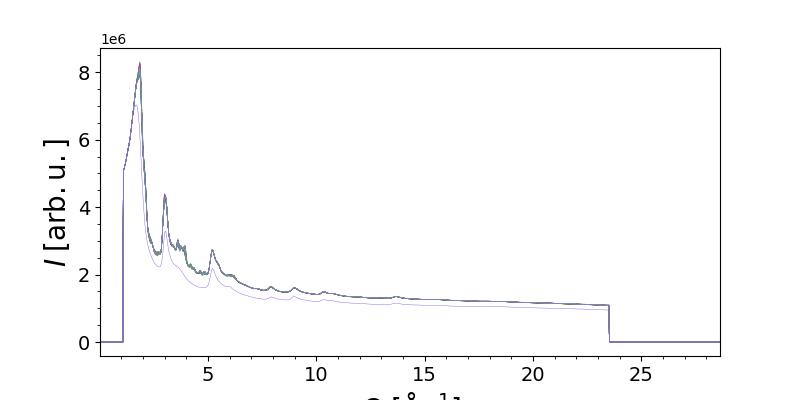

In [62]:
%matplotlib widget
bkg_dict_norm = data_files_to_dict(bkg_file_norm, 
                                   scan_split_index, 
                                   scan_split_index2, 
                                   type="bkg",
                                   )
data_bkg_dict_norm = data_files_to_dict(data_files_norm, 
                                        scan_split_index, 
                                        scan_split_index2, 
                                        type="data",
                                        )
data_bkg_dict_norm["bkg"] = bkg_dict_norm["bkg"]
stack_plotter(data_bkg_dict_norm, 
              basename, 
              xtype, 
              xunit, 
              D_PLOT, 
              plot_paths, 
              type="scaled", 
              mode="show",
              )

Saving stack plot.

In [63]:
stack_plotter(data_bkg_dict_norm, 
              basename, 
              xtype, 
              xunit, 
              D_PLOT, 
              plot_paths, 
              type="scaled", 
              mode="save",
              )
print(f"Stack plot of normalized data files and bkg saved to the "
      f"{plot_folders} folders.")

Stack plot of normalized data files and bkg saved to the ['png', 'pdf', 'svg'] folders.


Subtracting background.

In [64]:
data_dict_bkg_sub = dict_bkg_subtract(data_dict_norm, bkg_dict_norm)
data_bkg_sub_path = Path(f"{data_norm_path}_bkgsub")
if not data_bkg_sub_path.exists():
    data_bkg_sub_path.mkdir()
dict_bkg_sub_writer(data_dict_bkg_sub, 
                    basename, 
                    data_files_ext, 
                    data_bkg_sub_path, 
                    zfill,
                    )
print("Done subtracting background and writing background-subtracted files.")

Done subtracting background and writing background-subtracted files.


Stack plot of background-subtracted files.

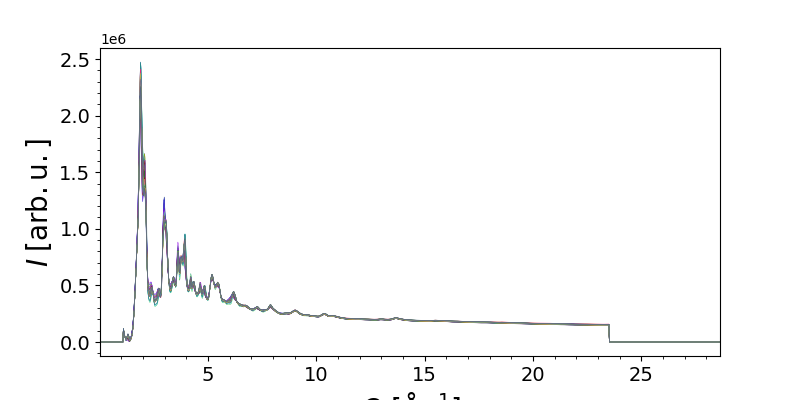

In [66]:
%matplotlib widget
stack_plotter(data_dict_bkg_sub, 
              basename, 
              xtype, 
              xunit, 
              D_PLOT, 
              plot_paths, 
              type="bkgsub", 
              mode="show",
              )

In [68]:
stack_plotter(data_dict_bkg_sub, 
              basename, 
              xtype, 
              xunit, 
              D_PLOT, 
              plot_paths, 
              type="bkgsub", 
              mode="save",
              )
print(f"Stack plot of background-subtracted data files saved to the "
      f"{plot_folders} folders.")

Stack plot of background-subtracted data files saved to the ['png', 'pdf', 'svg'] folders.


x-values to plot in overview plot.

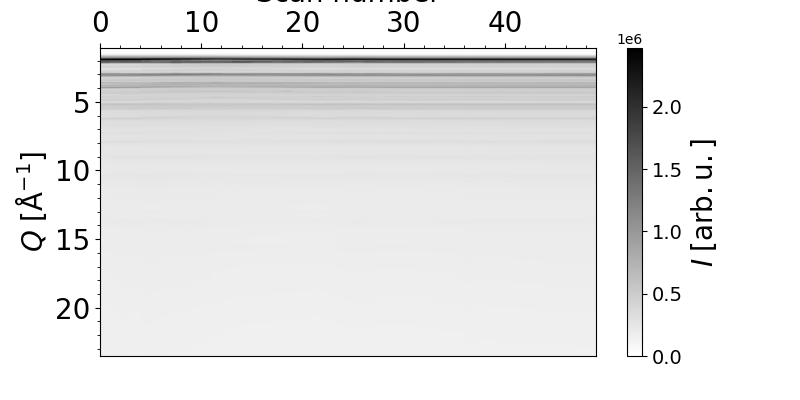

In [70]:
%matplotlib widget
xmin, xmax, xmin_index, xmax_index = extrema_collect(data_dict)
data_dict_overview(data_dict_bkg_sub, 
                   f"{xtype} {xunit}",
                   f"{basename}_ss_bkgsub", 
                   xmin, 
                   xmax, 
                   xmin_index,
                   xmax_index, 
                   D_PLOT,
                   plot_paths,
                   mode="show")

Saving overview plot.

In [71]:
data_dict_overview(data_dict_bkg_sub, 
                   f"{xtype} {xunit}",
                   f"{basename}_ss_bkgsub", 
                   xmin, 
                   xmax, 
                   xmin_index,
                   xmax_index, 
                   D_PLOT,
                   plot_paths,
                   mode="save")
print(f"Overview plot of bkg subtracted files saved to the {plot_folders} "
      f"folders.\n{80*'-'}\nDone working with files. <(^^,)>")

Overview plot of bkg subtracted files saved to the ['png', 'pdf', 'svg'] folders.
--------------------------------------------------------------------------------
Done working with files. <(^^,)>
